# Building a Multi-Output Model to Predict Macronutrient Profile

In this notebook we are going to improve on the current model to predict calores, and instead we will predict all 3 macronutrients. Here is how it will work:

- The user will input a recipe name.
- Then a list of suggested ingredients will appear, and the user can optionally edit this by either adding/subtracting ingredients or modifying quantities
    - This will be obtained for now by just running the cosine similarity with the recipe names in the data, and taking the ingredients from the top 5 or so results.
    - Quantities may be ignored if model can't handle numeric inputs, but LLMs can if going that route.
    - Being able to edit this could be a paid feature, i.e. changing quantities or adding/subtracting ingredients.
- The model will then take as input, the recipe name concatenated with the ingredients list. Perhaps with quantities as well if using an LLM.
    - Consider adding dietery type/preference here as well.
- Finally, a multi-output regression model will be used to predict the macronutrients, and we can take ratios by dividing each macro by the total calorie count. The aim here is that during training, the model will learn to optimize its parameters to minimize the error between the predicted and ground truth ratios derived from the normalized macronutrient values.

In [11]:
#keeping all imports at the top
import pandas as pd
import json
import os
import ast
from google.cloud import bigquery
import pandas_gbq

for module_name in ['pandas',]:
    module = __import__(module_name)
    print(f"{module_name}: {module.__version__}")

pandas: 2.2.0


## EDA and Preprocessing

In [2]:
df = pd.read_csv('../recipes.csv')
df.columns

Index(['uri', 'label', 'image', 'source', 'url', 'shareAs', 'yield',
       'dietLabels', 'healthLabels', 'cautions', 'ingredientLines',
       'ingredients', 'calories', 'totalWeight', 'totalTime', 'cuisineType',
       'mealType', 'dishType', 'totalNutrients', 'totalDaily', 'digest',
       'tags'],
      dtype='object')

In [3]:
df['ingredientLines']

0        ['1 pound green beans, trimmed', '1 tablespoon...
1        ['1 1/2 lb green beans, stem ends trimmed', '1...
2        ['1 stick (8 tbsp.) unsalted, cultured butter'...
3        ['2 teaspoons walnut oil', '1 pound green bean...
4        ['1 pound green beans, trimmed', '2 teaspoons ...
                               ...                        
13267    ['* 2tablespoons olive oil', '* 1 large red be...
13268    ['Two 6-ounce cans white meat tuna packed in w...
13269    ['16 ounces low-sodium chunk light tuna, drain...
13270    ['1 can (3 ounces) tuna, drained', '1 tablespo...
13271    ['1 can (3 ounces) chunk light tuna in water, ...
Name: ingredientLines, Length: 13272, dtype: object

Note the ingredientLines column is all we need if we concatenate ingredients with the recipe name, but since we want to adjust the ingredients and quantity for the input, we will need to get the information from the ingredients column manually instead.

In [4]:
ingredients_col = df['ingredients'].apply(ast.literal_eval)

In [5]:
ingredients_col[0]

[{'text': '1 pound green beans, trimmed',
  'quantity': 1.0,
  'measure': 'pound',
  'food': 'green beans',
  'weight': 453.59237,
  'foodCategory': 'vegetables',
  'foodId': 'food_aceucvpau4a8v6atkx5eabxyoqdn',
  'image': 'https://www.edamam.com/food-img/891/89135f10639878a2360e6a33c9af3d91.jpg'},
 {'text': '1 tablespoon butter, (optional)',
  'quantity': 1.0,
  'measure': 'tablespoon',
  'food': 'butter',
  'weight': 14.2,
  'foodCategory': 'Dairy',
  'foodId': 'food_awz3iefajbk1fwahq9logahmgltj',
  'image': 'https://www.edamam.com/food-img/713/71397239b670d88c04faa8d05035cab4.jpg'},
 {'text': 'Coarse salt and ground pepper',
  'quantity': 0.0,
  'measure': None,
  'food': 'Coarse salt',
  'weight': 2.80675422,
  'foodCategory': 'Condiments and sauces',
  'foodId': 'food_a1vgrj1bs8rd1majvmd9ubz8ttkg',
  'image': 'https://www.edamam.com/food-img/694/6943ea510918c6025795e8dc6e6eaaeb.jpg'},
 {'text': 'Coarse salt and ground pepper',
  'quantity': 0.0,
  'measure': None,
  'food': 'groun

In [6]:
def get_ingredient_aspect(row, aspect):
    lst = []
    for j in range(len(row)):
        lst.append(row[j][aspect])
    return lst

food_ingredients = ingredients_col.apply(lambda row: get_ingredient_aspect(row, 'food')).rename('foodItem')
quantity_ingredients = ingredients_col.apply(lambda row: get_ingredient_aspect(row, 'quantity')).rename('quantity')
measure_ingredients = ingredients_col.apply(lambda row: get_ingredient_aspect(row, 'measure')).rename('measurementUnit') # will need this to understand quantity

The `healthLabel` is the dietary type/preference like vegan, pescaterian, etc. We will only select few options though as it is a multilabel column, and the user can only select 1 for now, from: ['Mediterranean', 'Vegetarian', 'Vegan', 'Red-Meat-Free', 'Paleo', 'Pescatarian']. When reducing the healthLabels column from multilabel to categorical, we need to define a priority order, and if none of these are there then the dish is balanced, so we will add that as an option. In the future, some analysis on this column should be done to improve the priority order, rather than relying on domain knowledge. Alternatively, and option to select multiple could be implemented instead.

In [7]:
health_labels = df['healthLabels'].apply(ast.literal_eval)

Let's take a look at all unique values of health labels. If we had more data it might be worth it to just keep all of these health labels. 

In [8]:
unique_health_labels = []
for lst in health_labels:
    for health in lst:
        unique_health_labels.append(health)

print(set(unique_health_labels))


{'Keto-Friendly', 'Pescatarian', 'Tree-Nut-Free', 'Celery-Free', 'Mustard-Free', 'Mediterranean', 'Alcohol-Free', 'Gluten-Free', 'Paleo', 'Sulfite-Free', 'Sugar-Conscious', 'Pork-Free', 'Red-Meat-Free', 'Kidney-Friendly', 'Low Sugar', 'Lupine-Free', 'Soy-Free', 'Alcohol-Cocktail', 'Kosher', 'Sesame-Free', 'FODMAP-Free', 'Shellfish-Free', 'Vegetarian', 'Peanut-Free', 'Fish-Free', 'Wheat-Free', 'Vegan', 'DASH', 'Crustacean-Free', 'Low Potassium', 'Mollusk-Free', 'No oil added', 'Egg-Free', 'Immuno-Supportive', 'Dairy-Free'}


In [9]:
priority_order = ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean']

def replace_with_priority(labels):
    for label in priority_order:
        if label in labels:
            return label
    return 'Balanced'  # Handle case where no label matches priority_order, in which case the diet is balanced

# Apply function to the multilabels series
priority_health_labels = health_labels.apply(replace_with_priority)

### Target Variable

Now let's get the macros and calories can be calcualted from that.

In [11]:
df.columns

Index(['uri', 'label', 'image', 'source', 'url', 'shareAs', 'yield',
       'dietLabels', 'healthLabels', 'cautions', 'ingredientLines',
       'ingredients', 'calories', 'totalWeight', 'totalTime', 'cuisineType',
       'mealType', 'dishType', 'totalNutrients', 'totalDaily', 'digest',
       'tags'],
      dtype='object')

In [12]:
nutrients = df['totalNutrients'].apply(ast.literal_eval)

In [13]:
nutrients[0].keys()

dict_keys(['ENERC_KCAL', 'FAT', 'FASAT', 'FATRN', 'FAMS', 'FAPU', 'CHOCDF', 'CHOCDF.net', 'FIBTG', 'SUGAR', 'PROCNT', 'CHOLE', 'NA', 'CA', 'MG', 'K', 'FE', 'ZN', 'P', 'VITA_RAE', 'VITC', 'THIA', 'RIBF', 'NIA', 'VITB6A', 'FOLDFE', 'FOLFD', 'FOLAC', 'VITB12', 'VITD', 'TOCPHA', 'VITK1', 'WATER'])

In [14]:
for nutrient in nutrients[1].keys():
    print(nutrients[1][nutrient])

    #just want to look at these more closely, but we don't need to look at the micronutrients
    if nutrients[0][nutrient]['label'] == 'Cholesterol':
        break

{'label': 'Energy', 'quantity': 331.96545205, 'unit': 'kcal'}
{'label': 'Fat', 'quantity': 15.008954821, 'unit': 'g'}
{'label': 'Saturated', 'quantity': 2.2059442775, 'unit': 'g'}
{'label': 'Trans', 'quantity': 0.0, 'unit': 'g'}
{'label': 'Monounsaturated', 'quantity': 9.9235888555, 'unit': 'g'}
{'label': 'Polyunsaturated', 'quantity': 2.19255406715, 'unit': 'g'}
{'label': 'Carbs', 'quantity': 47.8064322835, 'unit': 'g'}
{'label': 'Carbohydrates (net)', 'quantity': 29.2874412985, 'unit': 'g'}
{'label': 'Fiber', 'quantity': 18.518990985000002, 'unit': 'g'}
{'label': 'Sugars', 'quantity': 22.359966893000003, 'unit': 'g'}
{'label': 'Protein', 'quantity': 12.551760556500001, 'unit': 'g'}
{'label': 'Cholesterol', 'quantity': 0.0, 'unit': 'mg'}


Calories is fat x 9 + protein x 4 + carbs x 4 + fiber x 2

In [15]:
fat = 2.2059442775 + 9.9235888555 + 2.19255406715 #adding up all the different types of fat doesn't result in the total fat for some reason
(15.008954821*9 + 29.2874412985*4 + 12.551760556500001*4) + 18.518990985000002*2

339.47538277900003

In [16]:
#net carbs + fiber
18.518990985000002 + 29.2874412985

47.8064322835

For some reason when you add this up the calories isn't an exact match with the recorded calories in the calories column (which is the same as the Energy label here). And carbs is just net carbs + fiber, and since fiber is insoluble we won't be counting/predicting it. Also the discrepency doesn't seem to be just from counting or not counting Fiber. Thus, we will just use the calculation for now instead, counting only net carbs, protein, and fat.

In [17]:
def get_macros(nutrients_row):
    macros_dct = {}

    for nutrient in nutrients_row.keys():
        if nutrients_row[nutrient]['label'] == 'Fat':
            macros_dct['fat'] = nutrients_row[nutrient]['quantity']
        elif nutrients_row[nutrient]['label'] == 'Protein':
            macros_dct['protein'] = nutrients_row[nutrient]['quantity']
        elif nutrients_row[nutrient]['label'] == 'Carbohydrates (net)':
            macros_dct['carbs'] = nutrients_row[nutrient]['quantity']

    return macros_dct

In [18]:
macros_df = pd.DataFrame(list(nutrients.apply(lambda row: get_macros(row))))

#macros_df['calories'] = 9*macros_df['fat'] + 4*macros_df['protein'] + 4*macros_df['carbs']
macros_df.head(3)

,fat,carbs,protein
0,12.559853,19.920021,8.567392
1,15.008955,29.287441,12.551761
2,93.626455,29.120751,13.416711


In [19]:
recipe_name = df['label'].rename('recipeName')

relevant_cols_df = pd.concat([priority_health_labels, recipe_name, food_ingredients, quantity_ingredients, measure_ingredients, macros_df], axis=1)
relevant_cols_df.head()

,healthLabels,recipeName,foodItem,quantity,measurementUnit,fat,carbs,protein
0,Vegetarian,Green Beans,"[green beans, butter, Coarse salt, ground pepper]","[1.0, 1.0, 0.0, 0.0]","[pound, tablespoon, None, None]",12.559853,19.920021,8.567392
1,Vegan,Sauteed Green Beans,"[green beans, olive oil, green-bean]","[1.5, 1.0, 1.0]","[pound, tablespoon, <unit>]",15.008955,29.287441,12.551761
2,Vegetarian,Caramelized Green Beans,"[butter, green beans]","[8.0, 1.5]","[tablespoon, pound]",93.626455,29.120751,13.416711
3,Vegan,Sautéed Fresh Green Beans,"[walnut oil, green beans]","[2.0, 1.0]","[teaspoon, pound]",9.997903,19.368394,8.300740
4,Vegan,Fancy Green Beans,"[green beans, vegan margarine, sesame seeds, S...","[1.0, 2.0, 2.0, 0.0, 0.0]","[pound, teaspoon, teaspoon, None, None]",11.359097,20.608817,9.509045


In [20]:
ex_row = relevant_cols_df.iloc[1]

for i in range(len(ex_row['foodItem'])):
    quantity = ex_row['quantity'][i]
    unit = ex_row['measurementUnit'][i]
    food = ex_row['foodItem'][i]

    if quantity > 0:
        print(quantity, unit, food)
    else:
        print(food)


1.5 pound green beans
1.0 tablespoon olive oil
1.0 <unit> green-bean


In [21]:
idxs = []
for i, units in enumerate(relevant_cols_df['measurementUnit']):
    for u in units:
        if u == '<unit>':
            idxs.append(i)
            break

In [22]:
relevant_cols_df.iloc[idxs,:]

,healthLabels,recipeName,foodItem,quantity,measurementUnit,fat,carbs,protein
1,Vegan,Sauteed Green Beans,"[green beans, olive oil, green-bean]","[1.5, 1.0, 1.0]","[pound, tablespoon, <unit>]",15.008955,29.287441,12.551761
10,Vegan,Frenched Green Beans,"[green beans, salt, black pepper, Sherry vineg...","[2.0, 0.75, 0.25, 2.0, 1.5, 1.0]","[pound, teaspoon, teaspoon, teaspoon, tablespo...",22.281541,39.256213,16.777531
28,Vegan,Lemon Green Beans recipes,"[lemon, salt, green beans, olive oil]","[1.0, 0.0, 1.0, 1.5]","[<unit>, None, pound, tablespoon]",21.499903,24.845194,9.224740
29,Balanced,Southern Green Beans,"[green beans, bacon, onion, red wine vinegar, ...","[1.25, 2.0, 1.0, 2.0, 2.0]","[pound, slice, <unit>, tablespoon, teaspoon]",22.835379,38.038953,19.103845
32,Vegetarian,Crispy Green Beans,"[flour, egg, buttermilk, panko breadcrumbs, ca...","[0.6666666666666666, 1.0, 0.6666666666666666, ...","[cup, <unit>, cup, cup, tablespoon, None, None...",95.584178,170.094762,39.403952
...,...,...,...,...,...,...,...,...
13265,Pescatarian,Tuna melt pizza baguettes,"[baguette, red pepper, green pepper, sweetcorn...","[2.0, 1.0, 1.0, 198.0, 225.0, 100.0, 1.0]","[<unit>, <unit>, <unit>, gram, gram, gram, tab...",52.192541,343.546831,151.500834
13267,Pescatarian,Red Pepper Farro With Tuna,"[olive oil, red bell pepper, farro, Salt, Pepp...","[2.0, 1.0, 1.0, 0.0, 0.0, 10.0]","[tablespoon, <unit>, cup, None, None, ounce]",34.505177,110.728103,82.228005
13269,Pescatarian,Savory Tuna Sandwich,"[light tuna, black olives, capers, white vineg...","[16.0, 6.0, 2.0, 0.25, 1.0, 8.0, 2.0, 4.0]","[ounce, <unit>, teaspoon, cup, tablespoon, sli...",30.103793,164.929173,127.987906
13270,Pescatarian,Tiny Tuna Melts recipes,"[tuna, mayonnaise, lemon juice, coarse salt, g...","[3.0, 1.0, 2.0, 0.0, 0.0, 16.0, 0.25]","[ounce, tablespoon, teaspoon, None, None, <uni...",31.519834,24.483712,25.609022


In [23]:
df['ingredientLines'][13265]

"['2 part-baked baguette', '1 red pepper, diced', '1 green pepper, diced', '198g can sweetcorn, drained', '225g jar tuna', '100g cheddar, grated', '1 tbsp tomato purée']"

In [24]:
relevant_cols_df.iloc[13265]['measurementUnit']

['<unit>', '<unit>', '<unit>', 'gram', 'gram', 'gram', 'tablespoon']

These <unit> values are essentially missing data, even though it is in the ingredientLines column. We could cross reference to fill them in, but since we are going to concatenate all these foodItem, quantity, and measurementUnit columns to get the ingredientLines anyway, let's just use it directly. Then, to allow users to adjust the quantity, we will have to go through the ingredients and pull out the quantity instead, and put it in it's own column.

In [25]:
ingredientLines = df['ingredientLines'].apply(ast.literal_eval)

In [26]:
relevant_df = pd.concat([priority_health_labels, recipe_name, ingredientLines, macros_df], axis=1)
relevant_df.head()

,healthLabels,recipeName,ingredientLines,fat,carbs,protein
0,Vegetarian,Green Beans,"[1 pound green beans, trimmed, 1 tablespoon bu...",12.559853,19.920021,8.567392
1,Vegan,Sauteed Green Beans,"[1 1/2 lb green beans, stem ends trimmed, 1 ta...",15.008955,29.287441,12.551761
2,Vegetarian,Caramelized Green Beans,"[1 stick (8 tbsp.) unsalted, cultured butter, ...",93.626455,29.120751,13.416711
3,Vegan,Sautéed Fresh Green Beans,"[2 teaspoons walnut oil, 1 pound green beans, ...",9.997903,19.368394,8.300740
4,Vegan,Fancy Green Beans,"[1 pound green beans, trimmed, 2 teaspoons veg...",11.359097,20.608817,9.509045


In [27]:
#we are going to join/concatenate the list of ingredients in the ingredientLines column with a comma, 
#so let's get rid of the existing commas in the individual ingredients now
def comma_to_bracket(ingredient_list):
    """
    Input: ingredient_list (str): a list of strings, like ingredients of a recipe.
    Output: recipe (str): commas in individual elements from input string are removed, then they are all joined together with a comma, so commas seperate each ingredient now.
    """
    processed_ingredients = []
    for ingredient in ingredient_list:
        parts = ingredient.split(',', 1)  # Split at the first comma
        if len(parts) > 1:  # Check if there is a comma
            # Check if the part after the comma is already in brackets
            if '(' not in parts[1] and ')' not in parts[1]:
                parts[1] = f'({parts[1].strip()})'  # Put it in brackets
        processed_ingredients.append(' '.join(parts))

    # Join the processed strings with a comma and space now that we removed the commas in the individual strings
    recipe = ', '.join(processed_ingredients)

    return recipe

In [28]:
relevant_df['ingredientLines'] = relevant_df['ingredientLines'].apply(comma_to_bracket)

In [29]:
relevant_df.head(3)

,healthLabels,recipeName,ingredientLines,fat,carbs,protein
0,Vegetarian,Green Beans,"1 pound green beans (trimmed), 1 tablespoon bu...",12.559853,19.920021,8.567392
1,Vegan,Sauteed Green Beans,"1 1/2 lb green beans (stem ends trimmed), 1 ta...",15.008955,29.287441,12.551761
2,Vegetarian,Caramelized Green Beans,"1 stick (8 tbsp.) unsalted (cultured butter), ...",93.626455,29.120751,13.416711


## Modeling

Now we can build a model to predict the macros. But first we need to preprocess the input by concatenating the strings into just one.

### XGBoost (testing)

In [30]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

In [31]:
relevant_df.isna().sum()

healthLabels        0
recipeName          0
ingredientLines     0
fat                 0
carbs              19
protein             0
dtype: int64

In [32]:
relevant_df = relevant_df.dropna().reset_index(drop=True)

Functions to preprocess text

In [33]:
english_stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

#making a function to remove stop words - taken from the above link
def remove_stop_words(review):
    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

def lemmatizing_reviews(review):
    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review

In [34]:
recipes = relevant_df['healthLabels'] + ' ' + relevant_df['recipeName'] + ' ' + relevant_df['ingredientLines']
recipes = recipes.rename('fullRecipeInput')
recipes = recipes.apply(remove_stop_words)
recipes = recipes.apply(lemmatizing_reviews)
recipes = recipes.apply(lambda x: word_tokenize(x))

In [35]:
X = recipes
y = relevant_df[['fat', 'carbs', 'protein']]

Actually, our target has exponential decay so let's look at the distributions and see if a log transform makes sense.

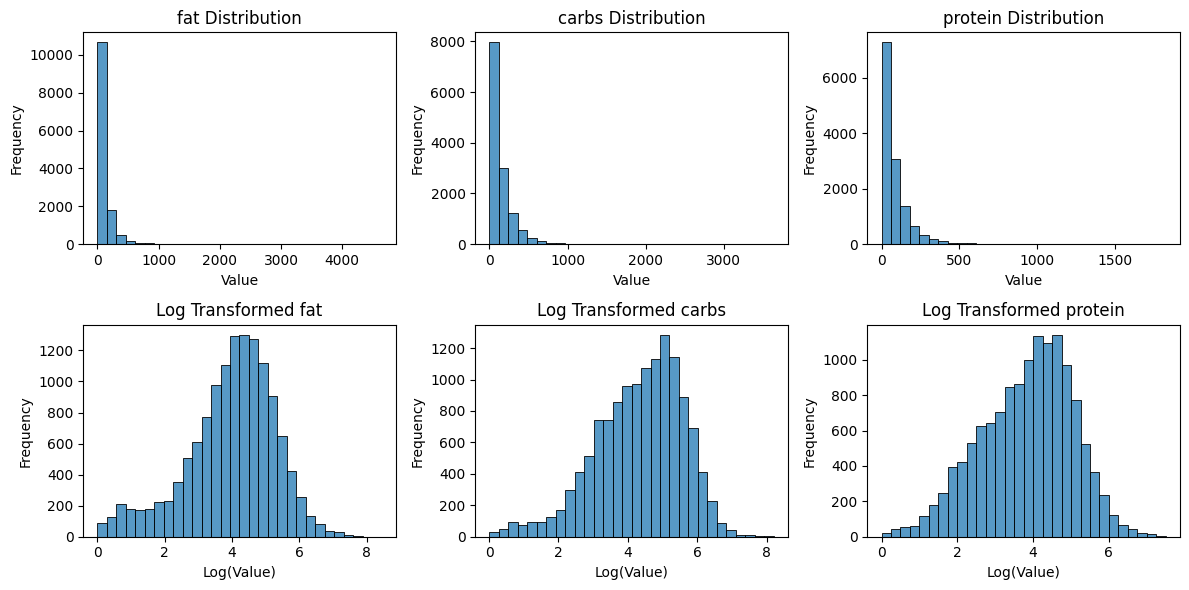

In [36]:
np.random.seed(0)
macro_names = y.columns

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

# Plot original target variables
for i in range(3):
    macro_name = macro_names[i]
    ax = axes[0, i]
    sns.histplot(y.iloc[:, i], bins=30, ax=ax)
    ax.set_title(f'{macro_name} Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Plot log-transformed target variables
for i in range(3):
    macro_name = macro_names[i]
    ax = axes[1, i]
    transformed_data = np.log1p(y.iloc[:, i])  # Log transformation
    sns.histplot(transformed_data, bins=30, ax=ax)
    ax.set_title(f'Log Transformed {macro_name}')
    ax.set_xlabel('Log(Value)')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

Log transforms are normally distributed so let's predict this instead. 

In [37]:
y = np.log1p(y)

In [38]:
test_size = 0.25
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

tfidf = TfidfVectorizer()

tfidf_X_train_labels = tfidf.fit_transform(X_train.str.join(' '))
tfidf_X_test_labels = tfidf.transform(X_test.str.join(' '))
tfidf_train_df = pd.DataFrame(tfidf_X_train_labels.toarray(), columns=tfidf.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_X_test_labels.toarray(), columns=tfidf.get_feature_names_out())

Let's try a multi output regressor.

In [87]:
model = XGBRegressor(objective='reg:squarederror', tree_method='hist', multi_strategy="multi_output_tree", random_state=10)

model.fit(tfidf_train_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy='multi_output_tree', n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

In [88]:
y_pred = model.predict(tfidf_X_test_labels)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: -6.8119616897648685


This is not great. The results below are immeditately better so let's just build a seperate model for each macronutrient.

In [89]:
xgb_regressor = XGBRegressor()

xgb_regressor.fit(tfidf_X_train_labels, y_train['fat'])

y_pred = xgb_regressor.predict(tfidf_X_test_labels)

r2 = r2_score(y_test['fat'], y_pred)
print("R-squared:", r2)

R-squared: 0.6525039385277662


Now we can use sklearns multioutput regressor, which under the hood build seperate models for each target anyway.

In [40]:
from sklearn.multioutput import MultiOutputRegressor

In [42]:
xgb_regressor = XGBRegressor()
regr = MultiOutputRegressor(xgb_regressor)

regr.fit(tfidf_X_train_labels, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [46]:
y_pred = regr.predict(tfidf_X_test_labels)

In [48]:
#overall r2 score
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.6345169834255278


In [63]:
#individual r2 scores
r2_scores = []
for i in range(len(np.asarray(y_test)[0])):
    r2 = r2_score(np.asarray(y_test)[:, i], y_pred[:, i])
    r2_scores.append(r2)

print("R2 Scores for each macro:")
for i, r2 in enumerate(r2_scores):
    macro = macro_names[i]
    print(macro, ":", r2)

R2 Scores for each macro:
fat : 0.6525039385277662
carbs : 0.5969464035011716
protein : 0.6541006082476455


Let's use grid search now to optimize this.

In [65]:
xgb_regressor = XGBRegressor()

# Create MultiOutputRegressor with XGBRegressor
regr = MultiOutputRegressor(xgb_regressor)

# Define parameter grid for XGBRegressor
param_grid = {
    #'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 3, 5, 7],
    'estimator__learning_rate': [None, 0.1, 0.01],
    #'estimator__subsample': [0.8, 0.9, 1.0],
    #'estimator__colsample_bytree': [0.8, 0.9, 1.0],
    #'estimator__gamma': [0, 0.1, 0.2],
    #'estimator__reg_alpha': [0, 0.1, 0.5],
    #'estimator__reg_lambda': [0, 0.1, 0.5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=regr, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

# Fit the grid search to the training data
grid_search.fit(tfidf_X_train_labels, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=None, ...)),
             param_grid={'estimator__learning_rate': [None, 0.1, 0.01],
                         'estimator__max_depth': [None, 3, 5, 7]},
             scoring='r2', verbose=1)

In [66]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R2 Score:", best_score)

Best Parameters: {'estimator__learning_rate': None, 'estimator__max_depth': None}
Best R2 Score: 0.5928360855371425


In [67]:
y_pred = grid_search.predict(tfidf_X_test_labels)

In [68]:
r2_scores = []
for i in range(len(np.asarray(y_test)[0])):
    r2 = r2_score(np.asarray(y_test)[:, i], y_pred[:, i])
    r2_scores.append(r2)

print("R2 Scores for each macro:")
for i, r2 in enumerate(r2_scores):
    macro = macro_names[i]
    print(macro, ":", r2)

R2 Scores for each macro:
fat : 0.6525039385277662
carbs : 0.5969464035011716
protein : 0.6541006082476455


### XGBoost (Operationalizing for each Macro with BigQuery)

MultiOutputRegressor still builds a regressor for each target variable seperately, but it is faster and easier to build and validate them seperately, so we will just do that. Here we will also test and define functions for scripting and load bigquery data.

In [21]:
import numpy as np
import pandas as pd
import json
import os
import ast
from google.cloud import storage
from google.cloud import bigquery
from google.cloud import aiplatform
import pandas_gbq
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

from xgboost import XGBRegressor

#### Preprocessing Bigquery Data

In [65]:
gcp_config_file = '../flavourquasar-gcp-key.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_config_file

with open(gcp_config_file, 'r') as file:
                gcp_config_data = json.load(file)
project_id = gcp_config_data.get('project_id', None)

client = bigquery.Client(project_id)

query = """
    SELECT healthLabels, label, ingredientLines, totalNutrients
    FROM `flavourquasar.edamam_recipes.edamam_raw_data`
"""

raw_df = pandas_gbq.read_gbq(query, project_id=project_id)
raw_df.columns

Downloading: 100%|██████████|


Index(['healthLabels', 'label', 'ingredientLines', 'totalNutrients'], dtype='object')

In [4]:
recipe_name = raw_df['label']

In [5]:
ingredient_lines = raw_df['ingredientLines'].apply(ast.literal_eval)

#we are going to join/concatenate the list of ingredients in the ingredientLines column with a comma, 
#so let's get rid of the existing commas in the individual ingredients now
def comma_to_bracket(ingredient_list):
    """
    Input: ingredient_list (str): a list of strings, like ingredients of a recipe.
    Output: recipe (str): commas in individual elements from input string are removed, then they are all joined together with a comma, so commas seperate each ingredient now.
    """
    processed_ingredients = []
    for ingredient in ingredient_list:
        parts = ingredient.split(',', 1)  # Split at the first comma
        if len(parts) > 1:  # Check if there is a comma
            # Check if the part after the comma is already in brackets
            if '(' not in parts[1] and ')' not in parts[1]:
                parts[1] = f'({parts[1].strip()})'  # Put it in brackets
        processed_ingredients.append(' '.join(parts))

    # Join the processed strings with a comma and space now that we removed the commas in the individual strings
    recipe = ', '.join(processed_ingredients)

    return recipe
ingredient_lines = ingredient_lines.apply(comma_to_bracket)

In [6]:
priority_order = ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean']

def replace_with_priority(labels):
    for label in priority_order:
        if label in labels:
            return label
    return 'Balanced'  # Handle case where no label matches priority_order, in which case the diet is balanced

# Apply function to the multilabels series
priority_health_labels = raw_df['healthLabels'].apply(ast.literal_eval)
priority_health_labels = priority_health_labels.apply(replace_with_priority)

In [7]:
nutrients = raw_df['totalNutrients'].apply(ast.literal_eval)
def get_macros(nutrients_row):
    macros_dct = {}

    for nutrient in nutrients_row.keys():
        if nutrients_row[nutrient]['label'] == 'Fat':
            macros_dct['fat'] = nutrients_row[nutrient]['quantity']
        elif nutrients_row[nutrient]['label'] == 'Protein':
            macros_dct['protein'] = nutrients_row[nutrient]['quantity']
        elif nutrients_row[nutrient]['label'] == 'Carbohydrates (net)':
            macros_dct['carbs'] = nutrients_row[nutrient]['quantity']

    return macros_dct
y = pd.DataFrame(list(nutrients.apply(lambda row: get_macros(row))))

y.head(3)

,fat,carbs,protein
0,45.801580,27.431000,106.040700
1,22.400004,185.135822,51.731469
2,82.503500,114.116200,72.999700


In [8]:
english_stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

#making a function to remove stop words - taken from the above link
def remove_stop_words(review):
    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

def lemmatizing_reviews(review):
    lemmatizer = WordNetLemmatizer()
    
    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review


X = priority_health_labels + ' ' + recipe_name + ' ' + ingredient_lines
X = X.rename('fullRecipeInput')
X = X.apply(remove_stop_words)
X = X.apply(lemmatizing_reviews)
X = X.apply(lambda x: word_tokenize(x))

In [9]:
def get_tfidf_splits(X, y, test_size=0.25, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    tfidf = TfidfVectorizer()

    tfidf_X_train_labels = tfidf.fit_transform(X_train.str.join(' '))
    tfidf_X_test_labels = tfidf.transform(X_test.str.join(' '))
    tfidf_train_df = pd.DataFrame(tfidf_X_train_labels.toarray(), columns=tfidf.get_feature_names_out())
    tfidf_test_df = pd.DataFrame(tfidf_X_test_labels.toarray(), columns=tfidf.get_feature_names_out())

    return tfidf_train_df, tfidf_test_df, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = get_tfidf_splits(X, y)

In [11]:
y_train, y_test = np.log1p(y_train), np.log1p(y_test)

#### Grid Search for Individual Models

In [20]:
xgb = XGBRegressor(objective='squarederror', random_state=42)
#xgb.get_params()

In [21]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [None, 100, 200],
    'learning_rate': [None, 0.1, 0.01], 
    'max_depth': [None, 3, 5, 7],
    #'reg_alpha': [0, 0.1, 0.5],
    #'reg_lambda': [0, 1, 2],
}

def grid_search_per_macro(param_grid, X_train, y_train, X_test, y_test, macro):
    
    xgb = XGBRegressor()

    grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train[macro])

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test[macro], y_pred)
    mse = mean_squared_error(y_test[macro], y_pred)

    print(f"Best parameters for {macro} macro: ", best_params)
    print(f"MSE score for {macro} macro: ", mse)
    print(f"R2 score for {macro} macro: ", r2)

    return best_model, best_params, mse, r2

In [ ]:
fat_model, fat_params, fat_mse, fat_r2 = grid_search_per_macro(param_grid, X_train, y_train, X_test, y_test, 'fat')

Best parameters for fat macro:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': None}
MSE score for fat macro:  1.7152445479570093
R2 score for fat macro:  -0.0010313932654573144


In [55]:
carbs_model, carbs_params, carbs_mse, carbs_r2 = grid_search_per_macro(param_grid, X_train, y_train, X_test, y_test, 'carbs')

Best parameters for carbs macro:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': None}
MSE score for carbs macro:  1.5824420364767808
R2 score for carbs macro:  -0.000978131293314144


In [56]:
protein_model, protein_params, protein_mse, protein_r2 = grid_search_per_macro(param_grid, X_train, y_train, X_test, y_test, 'protein')

Best parameters for protein macro:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': None}
MSE score for protein macro:  1.492547240089994
R2 score for protein macro:  -0.0006990023793680411


So in the training script we will use the best parameters to train the XGBoost model. It will look as follows.

In [8]:
def get_xgb_macro_model(X_train, X_test, y_train, y_test, macro, args):
    xgb = XGBRegressor(**args)
    xgb.fit(X_train, y_train[macro])
    y_pred = xgb.predict(X_test)
    r2 = r2_score(y_test[macro], y_pred)
    mse = mean_squared_error(y_test[macro], y_pred)

    return xgb, r2, mse


Vertex AI can't handle these large datasets (too many columns), so we will need to do some dimensionality reduciton.

In [80]:
from sklearn.decomposition import TruncatedSVD

# Assuming tfidf_matrix is your TF-IDF matrix
# You may need to transpose your matrix depending on how it's formatted
svd = TruncatedSVD(n_components=1000)
svd.fit(X_train)

TruncatedSVD(n_components=1000)

In [81]:
X_train_reduced, X_test_reduced = svd.transform(X_train), svd.transform(X_test)

In [82]:
column_names = [f"component_{i+1}" for i in range(X_train_reduced.shape[1])]

X_train_reduced_df = pd.DataFrame(X_train_reduced, columns=column_names, index=X_train.index)
X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=column_names, index=X_test.index)

In [84]:
X_train_reduced_df.shape

(9954, 1000)

In [89]:
X_test_reduced_df.shape

(3318, 1000)

In [90]:
def SVD_reduction(X_train, X_test, n_components=1000):
    svd = TruncatedSVD(n_components=n_components)
    svd_fitted = svd.fit(X_train)
    X_train_reduced, X_test_reduced = svd.transform(X_train), svd.transform(X_test)

    #getting column names just to convert to dataframe
    column_names = [f"component_{i+1}" for i in range(X_train_reduced.shape[1])]
    X_train_reduced_df = pd.DataFrame(X_train_reduced, columns=column_names, index=X_train.index)
    X_test_reduced_df = pd.DataFrame(X_test_reduced, columns=column_names, index=X_test.index)

    return X_train_reduced_df, X_test_reduced_df, svd_fitted

In [91]:
X_train_reduced_df, X_test_reduced_df, svd_fitted = SVD_reduction(X_train, X_test, n_components=1000)

In [92]:
print(X_train_reduced_df.shape)
print(X_test_reduced_df.shape)

(9954, 1000)
(3318, 1000)


#### Training Models on Preprocessed Data from GCP

In [3]:
def load_data_from_vertex_ai(client, table_id, dataset_id='macro_training_data', project_id='flavourquasar'):
    query = f"SELECT * FROM {project_id}.{dataset_id}.{table_id}"
    query_job = client.query(query)
    return query_job.to_dataframe()

In [4]:
gcp_config_file = '../flavourquasar-gcp-key.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_config_file
with open(gcp_config_file, 'r') as file:
        gcp_config_data = json.load(file)
project_id = gcp_config_data.get('project_id', None)
client = bigquery.Client(project_id)

X_train = load_data_from_vertex_ai(client=client, table_id='X_train')
y_train = load_data_from_vertex_ai(client=client, table_id='y_train')
X_test = load_data_from_vertex_ai(client=client, table_id='X_test')
y_test = load_data_from_vertex_ai(client=client, table_id='y_test')


Forgot to remove nulls, in which the carbs column has some in this case. Will need to return to this later to do it in preprocessing steps, but we can do it here for now.

In [49]:
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]
X_train.shape

In [53]:
y_test = y_test.dropna()
print(y_test.shape)
X_test = X_test.loc[y_test.index]
X_test.shape

(3312, 3)


(3312, 1000)

In [9]:
args = {'objective': 'reg:squarederror', 'random_state': 42}

fat_xgb, fat_r2, fat_mse = get_xgb_macro_model(X_train, X_test, y_train, y_test, 'fat', args)

#print(fat_xgb)
print(fat_mse)
print(fat_r2)

2.07515391695902
-0.2110775802832192


#### Predictions

Let's test out loading the models from GCP and then getting predictions from what a real user input would look like.

So user input will consist of 3 things:
1. Select health label type, one of: ['Vegan', 'Vegetarian', 'Pescatarian', 'Paleo', 'Red-Meat-Free', 'Mediterranean', 'Balanced']
2. Enter a recipe name as text.
3. After the recipe name is entered, we will run cosine similarity to find the most similar recipe in our database, and then populate the list of ingredients there, of which the user can then edit them to their liking or leave them as is. 

Then the model will take all three of these inputs and give the prediction. So let's run through an example. The health label will be Vegetarian with recipe name Black Bean Tacos.

In [67]:
health_label_ex = 'Vegetarian'
recipe_name_ex = 'Black Bean Tacos'

In [22]:
import pickle
def load_artifact_from_gcs(artifact_path, bucket_name='macro_predictor'):
    """
    Loads an artifact from a pickle file stored in Google Cloud Storage.
    Args:
        bucket_name (str): Name of the GCS bucket.
        artifact_path (str): Path within the bucket where the artifact is stored.
    Returns:
        object: Loaded pickle file.
    """
    # Initialize a client and bucket
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Get the blob (pickle file) from GCS
    blob = bucket.blob(artifact_path)

    # Download the pickle file contents as bytes
    pickle_bytes = blob.download_as_string()

    # Load the dictionary from the downloaded pickle file contents
    loaded_artifact = pickle.loads(pickle_bytes)

    return loaded_artifact

In [23]:
svd_fitted = load_artifact_from_gcs('macro_data_processing/svd_fitted.pkl')
tfidf_fitted = load_artifact_from_gcs('macro_data_processing/tfidf_fitted.pkl')

XGBoost_fat_model = load_artifact_from_gcs('training/XGBoost_fat_model.pkl')
XGBoost_carbs_model = load_artifact_from_gcs('training/XGBoost_carbs_model.pkl')
XGBoost_protein_model = load_artifact_from_gcs('training/XGBoost_protein_model.pkl')

In [26]:
XGBoost_fat_model.predict(svd_fitted.transform(tfidf_fitted.transform(['Vegan Black Bean Tacos'])))

c:\Users\RaviB\anaconda3\envs\edamam\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


array([3.9917119], dtype=float32)

In [83]:
from sklearn.metrics.pairwise import cosine_similarity

def remove_stop_words(review):
    english_stop_words = stopwords.words('english')

    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

def lemmatizing_reviews(review):
    lemmatizer = WordNetLemmatizer()

    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review

recipe_name_ex = lemmatizing_reviews(remove_stop_words(recipe_name_ex))


In [69]:
raw_df.columns

Index(['healthLabels', 'label', 'ingredientLines', 'totalNutrients'], dtype='object')

In [124]:
raw_df['ingredientLines'] = raw_df['ingredientLines'].apply(ast.literal_eval)

In [81]:
recipe_names_tdidf = raw_df['label'].apply(remove_stop_words)
recipe_names_tdidf = recipe_names_tdidf.apply(lemmatizing_reviews)
recipe_names_tdidf = tfidf_fitted.transform(recipe_names_tdidf)

recipe_name_ex = tfidf_fitted.transform([recipe_name_ex])

In [88]:
cosine_similarities = cosine_similarity(recipe_name_ex, recipe_names_tdidf)

most_similar_index = cosine_similarities.argmax()

In [89]:
most_similar_index

6465

In [92]:
raw_df.loc[most_similar_index, 'ingredientLines']

"['4 Breaded Chicken Cutlets', '8 toasted tortillas', '2 avocados, mashed', '8 tablespoons pico de gallo', 'Cilantro leaves']"

In [114]:
for idx in raw_df.index:
    recipe_names_df = raw_df['label']
    if recipe_names_df[1] == recipe_names_df[idx]:
        print(idx)


1


In [112]:
recipe_names_df = raw_df['label']
recipe_names_df[1] in recipe_names_df

False

In [115]:
raw_df.columns

Index(['healthLabels', 'label', 'ingredientLines', 'totalNutrients'], dtype='object')

In [151]:
def get_similar_ingredients(user_recipe_name, df, tfidf_fitted, recipe_name_col='label', ingredients_col='ingredientLines'):
    recipe_names_df = df[recipe_name_col]

    #if the recipe is a direct match with something in our database, then return that
    for idx in df.index:
        if user_recipe_name == recipe_names_df[idx]:
            return df['ingredientLines'][idx]
    
    #otherwise, take the cosine similarity, for which we need to preprocess all the text and perform tfidf first
    user_recipe_name = lemmatizing_reviews(remove_stop_words(user_recipe_name))
    user_recipe_name = tfidf_fitted.transform([user_recipe_name])

    recipe_names_tdidf = recipe_names_df.apply(remove_stop_words)
    recipe_names_tdidf = recipe_names_tdidf.apply(lemmatizing_reviews)
    recipe_names_tdidf = tfidf_fitted.transform(recipe_names_tdidf)

    #get the cosine similarities and take the max to get the most relevant recipe's index
    cosine_similarities = cosine_similarity(user_recipe_name, recipe_names_tdidf)
    most_similar_index = cosine_similarities.argmax()

    #use that index to return the ingredients list
    return df.loc[most_similar_index, ingredients_col]


In [152]:
user_input_recipe = 'Black Bean Tacos'
cosine_ingred = get_similar_ingredients(user_input_recipe, raw_df, tfidf_fitted)
cosine_ingred

['4 Breaded Chicken Cutlets',
 '8 toasted tortillas',
 '2 avocados, mashed',
 '8 tablespoons pico de gallo',
 'Cilantro leaves']

Now that we have the most relevant ingredients, we can apply the model after concatenating these three inputs

In [127]:
#we need this function to preprocess the ingredients list
def comma_to_bracket(ingredient_list):
    """
    Input: ingredient_list (str): a list of strings, like ingredients of a recipe.
    Output: recipe (str): commas in individual elements from input string are removed, then they are all joined together with a comma, so commas seperate each ingredient now.
    """
    processed_ingredients = []
    for ingredient in ingredient_list:
        parts = ingredient.split(',', 1)  # Split at the first comma
        if len(parts) > 1:  # Check if there is a comma
            # Check if the part after the comma is already in brackets
            if '(' not in parts[1] and ')' not in parts[1]:
                parts[1] = f'({parts[1].strip()})'  # Put it in brackets
        processed_ingredients.append(' '.join(parts))

    # Join the processed strings with a comma and space now that we removed the commas in the individual strings
    recipe = ', '.join(processed_ingredients)

    return recipe

In [134]:
health_label_ex = 'Vegetarian'
full_user_input = health_label_ex + ' ' + user_input_recipe + ' ' + comma_to_bracket(cosine_ingred)

In [141]:
full_user_input = remove_stop_words(full_user_input)
full_user_input = lemmatizing_reviews(full_user_input)
full_user_input = tfidf_fitted.transform([full_user_input])
full_user_input = svd_fitted.transform(full_user_input)

c:\Users\RaviB\anaconda3\envs\edamam\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


In [148]:
predicted_fat = np.expm1(XGBoost_fat_model.predict(full_user_input)[0])
predicted_carbs = np.expm1(XGBoost_carbs_model.predict(full_user_input)[0])
predicted_protein = np.expm1(XGBoost_protein_model.predict(full_user_input)[0])

In [150]:
print(predicted_fat, predicted_carbs, predicted_protein)

53.39393 73.18846 44.4972


In [153]:
calories_ex = 9*predicted_fat + 4*(predicted_carbs + predicted_protein)
calories_ex

951.2880020141602

#### Testing Flask App

In [19]:
import requests
url = 'http://127.0.0.1:5000/predict_macros'
data = {
    'user_input': 'Vegan Black Bean Tacos'
}

response = requests.post(url, json=data)
print(response.status_code)

200


In [20]:
print(response.json())

{'calories': 957, 'predicted_carbs': 74, 'predicted_fat': 53, 'predicted_protein': 46}


In [26]:
import pickle
import json
import ast
import pandas_gbq
from sklearn.metrics.pairwise import cosine_similarity
import os
from google.cloud import storage
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def remove_stop_words(review):
    english_stop_words = stopwords.words('english')

    #get the words in the review as a list
    review_words = review.split()
    
    #make a new list with the same words but only if they are not a stop word
    removed_stop_words_list = [word for word in review_words if word not in english_stop_words]
    
    removed_stop_words = ' '.join(removed_stop_words_list)
    
    return removed_stop_words

def lemmatizing_reviews(review):
    lemmatizer = WordNetLemmatizer()

    #get review text as a list of words
    review_list = review.split()
    
    #lemmatize the words
    lemmatized_list = [lemmatizer.lemmatize(word) for word in review_list]
    
    #make it into a string again
    lemmatized_review = ' '.join(lemmatized_list)
    
    return lemmatized_review

def load_artifact_from_gcs(artifact_path, bucket_name='macro_predictor'):
    """
    Loads an artifact from a pickle file stored in Google Cloud Storage.
    Args:
        bucket_name (str): Name of the GCS bucket.
        artifact_path (str): Path within the bucket where the artifact is stored.
    Returns:
        object: Loaded pickle file.
    """
    # Initialize a client and bucket
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Get the blob (pickle file) from GCS
    blob = bucket.blob(artifact_path)

    # Download the pickle file contents as bytes
    pickle_bytes = blob.download_as_string()

    # Load the dictionary from the downloaded pickle file contents
    loaded_artifact = pickle.loads(pickle_bytes)

    return loaded_artifact

def get_similar_ingredients(user_recipe_name, df, tfidf_fitted, recipe_name_col='label', ingredients_col='ingredientLines'):
    recipe_names_df = df[recipe_name_col]

    #if the recipe is a direct match with something in our database, then return that
    for idx in df.index:
        if user_recipe_name == recipe_names_df[idx]:
            return df['ingredientLines'][idx]
    
    #otherwise, take the cosine similarity, for which we need to preprocess all the text and perform tfidf first
    user_recipe_name = lemmatizing_reviews(remove_stop_words(user_recipe_name))
    user_recipe_name = tfidf_fitted.transform([user_recipe_name])

    recipe_names_tdidf = recipe_names_df.apply(remove_stop_words)
    recipe_names_tdidf = recipe_names_tdidf.apply(lemmatizing_reviews)
    recipe_names_tdidf = tfidf_fitted.transform(recipe_names_tdidf)

    #get the cosine similarities and take the max to get the most relevant recipe's index
    cosine_similarities = cosine_similarity(user_recipe_name, recipe_names_tdidf)
    most_similar_index = cosine_similarities.argmax()

    #use that index to return the ingredients list
    return df.loc[most_similar_index, ingredients_col]

def comma_to_bracket(ingredient_list):
    """
    Input: ingredient_list (str): a list of strings, like ingredients of a recipe.
    Output: recipe (str): commas in individual elements from input string are removed, then they are all joined together with a comma, so commas seperate each ingredient now.
    """
    processed_ingredients = []
    for ingredient in ingredient_list:
        parts = ingredient.split(',', 1)  # Split at the first comma
        if len(parts) > 1:  # Check if there is a comma
            # Check if the part after the comma is already in brackets
            if '(' not in parts[1] and ')' not in parts[1]:
                parts[1] = f'({parts[1].strip()})'  # Put it in brackets
        processed_ingredients.append(' '.join(parts))

    # Join the processed strings with a comma and space now that we removed the commas in the individual strings
    recipe = ', '.join(processed_ingredients)

    return recipe

def predict_ingredients(user_input_recipe):
    gcp_config_file = '../flavourquasar-gcp-key.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_config_file

    with open(gcp_config_file, 'r') as file:
                    gcp_config_data = json.load(file)
    project_id = gcp_config_data.get('project_id', None)

    query = """
        SELECT label, ingredientLines
        FROM `flavourquasar.edamam_recipes.edamam_raw_data`
    """

    df = pandas_gbq.read_gbq(query, project_id=project_id)
    df['ingredientLines'] = df['ingredientLines'].apply(ast.literal_eval)

    tfidf_fitted = load_artifact_from_gcs('macro_data_processing/tfidf_fitted.pkl')
    cosine_ingred = get_similar_ingredients(user_input_recipe, df, tfidf_fitted)

    ingredients_lst = comma_to_bracket(cosine_ingred)

    ingredients_lst = [item.strip() for item in ingredients_lst.split(',')]

    return ingredients_lst

In [27]:
predict_ingredients('Black Bean Tacos')

Downloading: 100%|██████████|


['4 Breaded Chicken Cutlets',
 '8 toasted tortillas',
 '2 avocados (mashed)',
 '8 tablespoons pico de gallo',
 'Cilantro leaves']

In [30]:
import requests
url = 'http://127.0.0.1:5000/predict_ingredients'
data = {
    'user_input': 'Black Bean Tacos'
}

response = requests.post(url, json=data)
print(response.status_code)

200


In [31]:
print(response.json())

['4 Breaded Chicken Cutlets', '8 toasted tortillas', '2 avocados (mashed)', '8 tablespoons pico de gallo', 'Cilantro leaves']


### Transformers

In [68]:
import torch
from datasets import Dataset
from transformers import BertModel, BertConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

import torch, random, datasets
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import numpy as np

In [31]:
X = relevant_df['healthLabels'] + ' ' + relevant_df['recipeName'] + ' ' + relevant_df['ingredientLines']
X = X.rename('fullRecipeInput')
y = relevant_df[['fat', 'carbs', 'protein']]

dataset = Dataset.from_pandas(pd.concat([X, y], axis=1))

In [32]:
dataset.train_test_split(test_size=0.2)

DatasetDict({
    train: Dataset({
        features: ['fullRecipeInput', 'fat', 'carbs', 'protein'],
        num_rows: 10617
    })
    test: Dataset({
        features: ['fullRecipeInput', 'fat', 'carbs', 'protein'],
        num_rows: 2655
    })
})

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y['fat'], test_size=0.25)

In [71]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

max_length = 100

# Encode the text
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)

In [73]:
class MakeTorchData(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        label = {k: torch.tensor(v[idx], dtype=torch.float32) for k, v in self.labels.items()}
        item.update(label)
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = MakeTorchData(train_encodings, y_train)
valid_dataset = MakeTorchData(valid_encodings, y_test)

In [77]:
from transformers import BertForSequenceClassification, BertConfig
import torch

# Load pre-trained BERT model configuration
config = BertConfig.from_pretrained('bert-base-uncased')
# Modify the number of labels to 3 (for the 3 regression targets)
config.num_labels = 3

# Instantiate the model with modified configuration
model = BertForSequenceClassification(config).to("cuda")

In [79]:
class CustomLoss(nn.Module):
    def __init__(self, weights):
        super(CustomLoss, self).__init__()
        self.weights = weights

    def forward(self, predictions, targets):
        loss = 0.0
        for i in range(len(predictions)):
            loss += self.weights[i] * torch.mean((predictions[i] - targets[:, i])**2)
        return loss

loss_fn = CustomLoss(weights=[1.0, 1.0, 1.0])

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=20,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    save_total_limit=10,
    load_best_model_at_end=True,
    metric_for_best_model='rmse',
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=loss_fn,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

  0%|          | 0/312 [00:00<?, ?it/s]

KeyError: 7450

In [74]:

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3).to("cuda")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [75]:
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 1,     
    per_device_train_batch_size = 32,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = valid_dataset,          
    compute_metrics = compute_metrics_for_regression,     
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

  0%|          | 0/312 [00:00<?, ?it/s]

KeyError: 7450

In [33]:
class MultiOutputRegressionModel(nn.Module):
    def __init__(self, num_outputs):
        super(MultiOutputRegressionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, num_outputs)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        x = torch.relu(self.fc1(pooled_output))
        x = self.fc2(x)
        return x
    
    

In [34]:
num_outputs = 3  # Number of output dimensions
model = MultiOutputRegressionModel(num_outputs=num_outputs)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)